## Deep learning or bust?
Boosting and bagging, Bayes and Markov, clusters and neighbors. All of these are old and tired terms for a "cutting edge" data scientist these days. Everyone knows that any data scientist worth their salt is knee deep in convolutional, recurrent, and deep belief neural networks. Obviously.

And yet, somewhere in a dark corner of the machine learning world, there are data scientists looking over their shoulders hoping that no one will notice that they're still building **gasp** _linear models_.

It might not be glamorous and it might not impress the hipsters drinking kale smoothies at the local organic juice bar, but [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) are a crucial part of data science, machine learning, and statistics. In my opinion, it is hard to justify focusing on deep learning if you don't have a rich understanding of generalized linear models.

## Generalized Linear Models - what are they?
Most resources that give introductions to data science and machine learning start, appropriately, by going over linear regression. It makes a lot of sense to do this, since linear regression is one of the simplest machine learning models that exists and it can be very easy to understand. A very common next step is to introduce logistic regression, which is a linear model for performing classification. A logical next step. Very rarely, however, do these resources go on to explain that these two models are specific cases of a more general framework called _generalized linear models_, or GLMs.

>"A generalized linear model is a probabilistic framework for predicting an outcome variable using linear combinations of some predictor variables." - me (and probably some other people too)

That beautiful quote might not have cleared up much of the confusion surrounding generalized linear models, but we'll get there. In this post I'll build up a more sound intuition around one specific type of GLM - linear regression. [In a follow-up post](/glm-part-ii), I'll extend this to cover all GLMs.

## Understanding linear regression unscientifically (via least squares)
It is frustrating that most resources that explain linear regression do it an almost empirical manner. To be thorough, I will first introduce linear regression in this "empirical" manner - what I like to call the "yeah, that makes sense" method.

### The goal
First, let's start with stating what exactly we are trying to accomplish with a linear regression model. 

>We will try to predict an outcome variable using a linear combination of other input variables.

For example, we might try to predict what price a home would sell for by examining the square footage or we might try to predict a student's university gpa by examining their high school gpa. These are perhaps simple examples, but there is real value in predicting real world outcomes, even simple ones. 

So, how are we gonna do this? In both of these contrived scenarios that I have presented, we can imagine the general trend of the outcome related to the input variables. We might know that, in general, a larger home sells for a higher price and that a student with a higher high school gpa tends to have a high university gpa. Let's look at an example of a small dataset to see if we can confirm our presumptions.

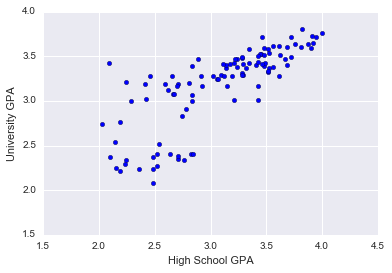

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('../../data/gpa.txt', delimiter=" ")
plt.scatter(df['high_GPA'], df['univ_GPA'])
plt.xlabel("High School GPA")
plt.ylabel("University GPA")

Hey, our assumptions appear correct! We can see that a student's college gpa tends to increase with high school gpa, and it looks like it might even be linear. There is some other stuff going on this plot, but we can clearly see that the general trend is, as high school GPA goes up, so too does university GPA. Based on this, we might think our goal of using linear combinations of the inputs (high school GPA) is a worthwhile endeavor. Let's get to the goal we stated previously then - predicting university GPA from high school GPA. 

## Our very first model
We know the two variables are related, and we know that they increase together. What if we just predicted that a student's college gpa would be the same as their high school gpa? 

**"yeah, that makes sense"**

That's not a bad place to start, and if we do that, we are actually creating a function, f, that maps high school gpa to university gpa like so $\tau$:

$$
{gpa}^u = f({gpa}^{hs}) = {gpa}^{hs}
$$

Here, we use Python to plot that function - a line - and visualize it alongside our original data.

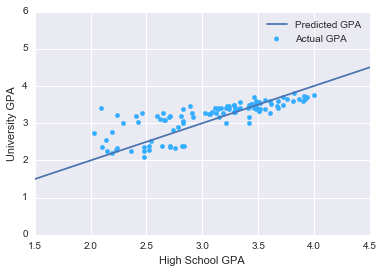

In [3]:
x = np.linspace(1.0, 5.0, 100)
y = x
plt.scatter(df['high_GPA'], df['univ_GPA'], color = '#33adff')
plt.plot(x, y)
plt.xlim([1.5, 4.5])
plt.xlabel("High School GPA")
plt.ylabel("University GPA")
plt.legend(["Predicted GPA", "Actual GPA"])

Let's look more closely at a specific student in our dataset:

In [4]:
idx = 22 # the 22nd data point
student = df.iloc[idx]
print "Student #22 high school GPA is %s" % student.high_GPA
print "Student #22 university GPA is %s" % student.univ_GPA

Student #22 high school GPA is 2.46
Student #22 university GPA is 3.28


Here we have a student whos high school GPA was 2.46 and whose university GPA was 3.28. In our model we predict that the student would have a university GPA of 2.46 (the same as the high school GPA), and so we were off by $3.28 - 2.46 = 0.82$. Let's visualize our error:

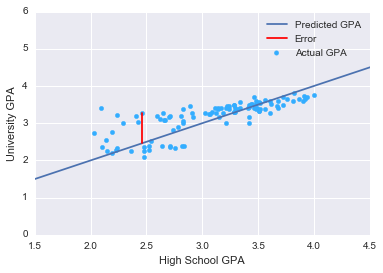

In [5]:
x = np.linspace(1.0, 5.0, 100)
y = x
plt.scatter(df['high_GPA'], df['univ_GPA'], color = '#33adff')
plt.plot(x, y)
plt.plot((df.iloc[idx]['high_GPA'], df.iloc[idx]['high_GPA']), \
         (df.iloc[idx]['high_GPA'], df.iloc[idx]['univ_GPA']), c='r')
plt.xlim([1.5, 4.5])
plt.xlabel("High School GPA")
plt.ylabel("University GPA")
plt.legend(["Predicted GPA", "Error", "Actual GPA"])

That red line in the plot above shows us how wrong we are for the given data sample. In this case, our model was off by "quite a bit." Still, with this line we now have a way to predict university GPA and it even looks like a decent prediction for most of our data points. 

Ok, well the logical next question we can ask ourselves is if there is a better line than the one we plotted above that helps us predict university GPA? To answer that, we need to define what "better" means. Since the length of the vertical line from a data point to our line is the magnitude of the error, then we might like to minimize the length of each of those vertical lines. That is, we want to find a line to explain our data that gives us the smallest error lines. 

**"yeah, that makes sense"**

Let's state this mathematically:

$$
minimize \sum \text{length of error line}
$$

The error line is simply the (magnitude of the) difference between the actual GPA and the GPA predicted by our model. We can't minimize this difference directly, since it can be negative - if we did, then we would find that being very wrong in the negative direction would be better. One very common way to combat this is to take the square of the difference. Squaring the difference makes it so that predicting too high is the same as predicting too low. 

**"yeah, that makes sense"**

Mathematically:

$$
min \sum \left(y_i - \hat{y}_i \right)^2
$$

where $y_i$ is the actual university GPA for the ith student and $\hat{y}_i$ is the predicted university GPA for the ith student. We can be more specific here by remembering that we use a linear function of the high school GPA to predict the university GPA. Let's state how we compute $\hat{y}_i$:

$$
\hat{y}_i = \alpha + \beta \cdot {gpa}^{hs}
$$

You might notice the above as the generic equation for a line in two dimensions where $\beta$ is the slope of the line and $\alpha$ is the intercept term. In the initial example that we came up with, we had $\beta = 1.0$ and $\alpha = 0.0$ which gave us $\hat{y}_i = {gpa}^{hs}$.

Ok, so now we are getting really close. We can now restate our goal: we want to find the alpha and beta that give us the minimum sum of squared errors for all of our data samples. Mathematically:

$$
min_{\alpha, \beta} \sum_{i=1}^{N} \left({gpa}^u_i - \left(\alpha + \beta \cdot {gpa}^{hs}_i \right) \right)^2
$$

We actually now have a rigorous mathematical definition of what we want to accomplish. We just want to find the "best" line that predicts our data. Finding the best line is the same as finding the best alpha and beta, since these are the two terms that define the line. To see that we have something concrete, let's compute the quantity we are trying to minimize by trying out some alphas and betas. Let's start with the initial model where $\beta = 1.0$ and $\alpha = 0.0$

In [6]:
def sum_squared_error(alpha, beta, gpa_u, gpa_hs):
    error = gpa_u - (alpha + beta * gpa_hs)
    sse = np.sum(error * error)
    print "sum of squared error for alpha=%0.2f and beta=%0.2f is: %0.2f" % (alpha, beta, sse)
sum_squared_error(0.0, 1.0, df['univ_GPA'], df['high_GPA'])
sum_squared_error(0.0, 1.01, df['univ_GPA'], df['high_GPA'])
sum_squared_error(0.0, 0.99, df['univ_GPA'], df['high_GPA'])
sum_squared_error(0.1, 1.0, df['univ_GPA'], df['high_GPA'])
sum_squared_error(-0.1, 1.0, df['univ_GPA'], df['high_GPA'])

sum of squared error for alpha=0.00 and beta=1.00 is: 12.07
sum of squared error for alpha=0.00 and beta=1.01 is: 11.73
sum of squared error for alpha=0.00 and beta=0.99 is: 12.62
sum of squared error for alpha=0.10 and beta=1.00 is: 11.09
sum of squared error for alpha=-0.10 and beta=1.00 is: 15.15


Ok, this is pretty cool, we can actually see that our error is less in some cases and greater in others, so we can concretely say that some of those alpha/beta pairs are _better_ than some others. Of the five examples we just looked at, we could just choose the alpha and beta that gave the lowest sum of squared errors, which was alpha=0.10 and beta=1.00. 

### Choosing the best parameters
The problem is that there are an infinity of possible values for alpha and beta, and we want to make sure we chose the two best. It would be quite taxing to try out every one of the possible combinations and see which one gives the lowest error. The great thing about linear regression is that there is a way to actually compute the best combination exactly, and eliminate the guesswork. For other generalized linear models, this will not be true, but we leave that hurdle for another day.

There are about 2.34e31 great resources on how to use a bit of calculus and linear algebra to find the best parameters for a linear regression, and so I will leave this part out for now. In Python NumPy, we can find the best parameters in a couple lines of code.

In [12]:
X = np.append(np.ones(df.shape[0]), df['high_GPA'].values).reshape(2, df.shape[0]).T
y = df['univ_GPA'].values[:, np.newaxis]
alpha, beta = np.dot(np.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, y)).ravel()
print "best alpha: %0.3f, best beta: %0.3f" % (alpha, beta)

best alpha: 1.097, best beta: 0.675


So, now that we have computed the optimal alpha and beta, we get a concrete method for predicting university GPA from high school GPA:

$$
{gpa}^u = 1.097 + 0.675 \cdot {gpa}^{hs}
$$

Neat! Let's compare this new, optimal, line to the original one.

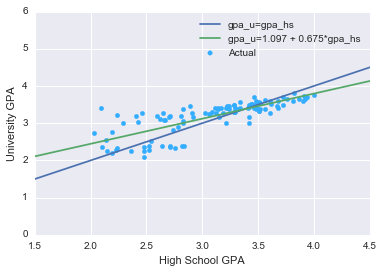

In [14]:
x = np.linspace(1.0, 5.0, 100)
y = x
plt.scatter(df['high_GPA'], df['univ_GPA'], color = '#33adff')
plt.plot(x, y)
plt.plot(x, alpha + beta * x)
plt.xlim([1.5, 4.5])
plt.xlabel("High School GPA")
plt.ylabel("University GPA")
plt.legend(["gpa_u=gpa_hs", "gpa_u=1.097 + 0.675*gpa_hs", "Actual"])

Well, the new line isn't _too_ far from our original, but it looks like it's a bit of a better fit - that's encouraging! Let's recap what we have done: 

Basically, we said we want to predict our outcome variable with a line because we think it might follow a linear relationship with our input (high school gpa). To find the best line, we said we'd like to choose one that minimizes our errors (seems reasonable). We said our errors should be the squared difference between predicted and actual because we need the error to be always positive (yeah, makes sense). We then used some calculus and linear algebra, and voila! We got our answer. Everything worked out nice and simple.

This more or less concludes the standard introduction to linear regression and generally follows the explanation that is common in various blogs, slides, and lectures. This is known as the method of [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) for solving linear regression. We made a lot of decisions that "made a lot of sense" and worked out well mathematically for us, but there is really a lot left to be desired in terms of rigor.

## Understanding linear regression probabilistically

Once we try to expand the linear regression problem to a more general problem, things get more complicated. The math doesn't work out as nicely, and some of the decisions we make can't just "make sense." We need rigor damnit!

If we want to have any shot at understanding GLMs, we'll need to restate our linear regression problem using _probability_ - woot!

### A data generation process

We start by making an assumption about how our data came to be. We assume that there is some process which takes data as input and generates an outcome as output. If we can figure out what this process is and how it works, we can generate future outcomes (i.e. predict) given future data. Really, we want to know what is in the black box.

<img src="../../images/blackbox.jpg" width="400">

In the real world, a university GPA is generated from a high school GPA through the process of a student going to college, doing coursework, and receiving grades. Their grades are determined partly by how smart/hardworking they are, which is reflected by their high school GPA, and partly by some other factors which we call random. We want to model this process, but it is complex. In a linear regression, we make some very specific assumptions about this process:

1. Assume that the expected value of an outcome $y_i$ can be computed directly from a linear combination of the inputs $\vec{x}_i$
2. Assume that each outcome $y_i$ is drawn from a Gaussian probability distribution, with mean equal to the expected value computed in (1)

That leaves us with the following data generation process.

1. A data point $x_i$ is received
2. Use a linear combination of the data to find a mean: $\mu_i = \alpha + \beta \cdot x_i$
3. Inject randomness by drawing a random sample from a normal distribution centered at $\mu$: $y_i \sim \mathcal{N}\left(\mu_i, \sigma^2 \right)$ ($\sigma^2$ is an unknown constant just like $\alpha$ and $\beta$)

You can imagine that data is generated by sliding a single normal distribution up and down the linear regression line, which corresponds to the expected values of Y for given data points X.

<img src="../../images/shafer-fig10_005.png" width="600">

For the high school GPA to university GPA process we have been studying, that might look like this:

<img src="../../images/example_process.jpg" width="400">

It is clear that specifying the process by which the data is generated has some advantages over the simple least squares approach. In the previous framework described above, we made several assumptions which, if invalidated, makes our model look quite silly. The terrible thing is that we didn't even really discuss what they were and we probably didn't even know we were making them! In this probabilistic view, our assumptions are clear because we state exactly how we _assume_ the data was generated. That is, we _assume_ the mean of the data changes linearly with the input, and we _assume_ that each normal distribution has the same variance. If this is not true, or not at least approximately true, it will be very obvious to us that we should rethink what we're doing!

Before, we said that the outcome was linearly related to the input, but yet we still had some error in every data point. We failed to explain those errors and how they arose. In this new framework, however, we are saying that there is some randomness in each sample - that's what drawing from a probability distribution tells us. This explains why the model is not perfect - by definition, we cannot explain or model this randomness.

One neat consequence of this view is that we have a way to "generate" synthetic data. We can see what this looks like with some simple Python code. The more error we have in general means that the normal distributions we are drawing from are wider, or that they have higher standard deviations.  The plots below show the centered normal distribution from which the outcomes are drawn and a plot of some simulated data for varying degrees of randomness

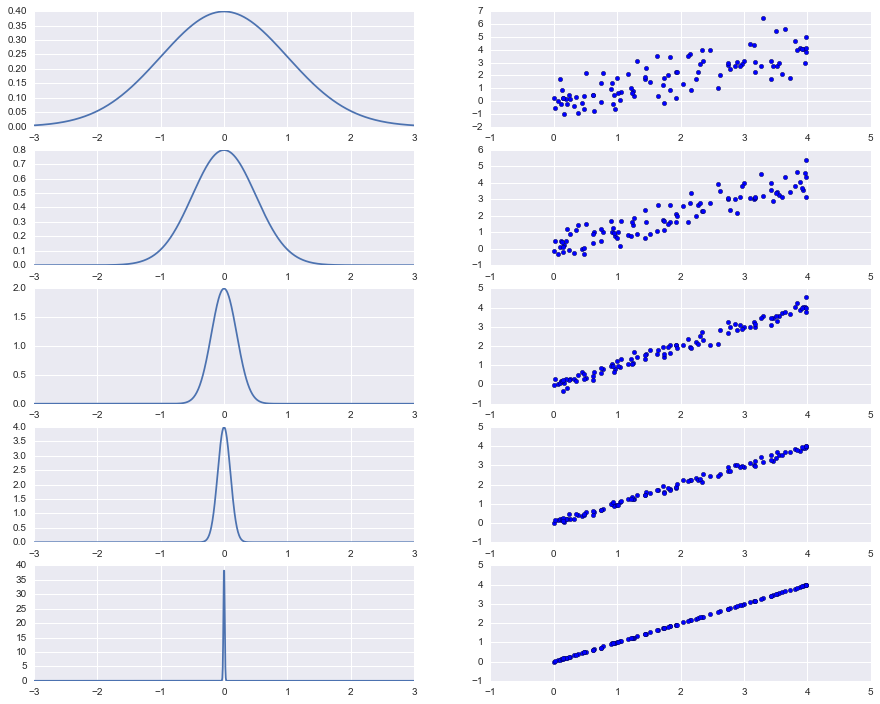

In [3]:
import matplotlib.mlab as mlab
x = np.linspace(-3, 3, 1000)
gpa_hs = np.random.random(100) * 4.0 # random values for high school gpas between 0 and 4
std_devs = [1.0, 0.5, 0.2, 0.1, 0.01]
fig, axs = plt.subplots(len(std_devs), 2, figsize=(15, 12))
for i, ax in enumerate(axs.reshape(-1)):
    gpa_u = [np.random.randn()*std_devs[i / 2] + gpa for gpa in gpa_hs]
    if i % 2 != 0:
        ax.scatter(gpa_hs, gpa_u)
    else:
        ax.plot(x,mlab.normpdf(x, 0.0, std_devs[i / 2]))

We can see that when the normal distribution is thin, that we have very little randomness and that our linear model almost perfectly captures the relationship between input and outcome. This makes our data appear in almost exactly a straight line.

One thing to note is that the probability of very large errors in the data is very small. It decreases exponentially as we move further away from the mean. In other words, we are in the tails of the normal distributions where the probabilities are very low.

## Likelihood
The nice thing about the framework we are developing here is that it provides us with probability density functions, or measures of "likelihood," for our data. That is, if we guess values for our unknown parameters, we can get a measure of how likely or unlikely it was to see the specific data that we saw. For example, assume we have a simple model for university GPA: $gpa^u = \beta \cdot gpa^{hs}$. Now, we guess that $\beta = 2$ and $\sigma^2$ = 0.25. Then we look at a real data point from our real dataset, where a student with $gpa^{hs} = 2.46$ ended up with $gpa^u = 3.28$. That means that, according to our model, the outcome was drawn from a normal distribution with mean of $2 \cdot 2.46 = 4.92$ and variance of $0.25$. With this in mind, we find that there is a 0.05% chance of observing a value as extreme or more extreme than $3.28$. This may signal to us that $\beta$ is not equal to 2 and in fact may be something much different!

For continuous outcome variables, we use the probability density function to find how likely or unlikely different values for the outcome are, given our assumptions about how the data was generated. We will write this density as:

$$
p\left(y|x; \alpha, \beta, \sigma^2 \right)
$$

That might look a little intense, but when you put it into words it doesn't seem so bad. The formula above just represents the probability density of the random variable y, given the random variable x, and for specific values of alpha, beta, and sigma. We saw above that we can find the likelihood of a single data point using the probability density function for a single data point in our model - a normal distribution. However, we'd like to consider _all_ of our data and find the likelihood of _all_ of our data occurring together. This is called the _joint probability density_ of the data, and is simply as the product of the individual probability densities - there are no assumptions here, this is just a result of probability theory. Computing this quantity will give us what we will call the "likelihood function" of our data. The likelihood of the data is a measure of how probable it was to observe the data that we observed, given specific choices for the model parameters.

Now we can formulate our problem in a more intuitive manner. Can we choose an alpha and beta and sigma that simply make our data most likely to have happened? If we chose alpha = 1,498 and beta = 485 and sigma = 0.1 then it is _very_ unlikely that the data would look like the data we have. And so, probably, alpha does not equal 1,498 and beta does not equal 485. 

This idea is a very deep subject in the field of probability, statistics, and machine learning and boatloads of information exists on the topic. For that reason, I'll try to give just a short, simple intuition here.

### Quick tangent: the MLE
Imagine flipping a coin that has some probability of heads, p, and some probability of tails, 1 - p. We don't know what p is, so we decided to flip it ten times and try to determine p. We flip ten times and the coin comes up heads all ten times. Now, we need to make a guess at what p is, what should we guess? Well, we know that a coin that is 50/50 _could_ come up heads 10 times in a row, but that it usually won't (in fact, the probability is (50%)^10 = 0.098%). We know that a coin that is 100/0 heads would come up heads every single time. Well, we decide that we should guess that p is whatever value that would make 10 heads in a row most likely, so we guess that p = 1. Without any other information, this is really the best we can do - to guess the p that maximizes the likelihood. That's what we call some _**maximum likelihood estimation**_!

### Linear regression likelihood function
We can now state the likelihood of a sequence of data points under a linear regression model as the product of the probabilities of the individual data points:

$$
\prod_{i=1}^{N} p\left(y_i|x_i; \alpha, \beta, \sigma^2 \right) = \prod_{i=1}^{N} \mathcal{N}\left(\mu_i\left(\alpha, \beta\right), \sigma^2\right) = \prod_{i=1}^{N} \mathcal{N}\left(\alpha + \beta \cdot x_i , \sigma^2\right)
$$

Now, we can state our goal as choosing the alpha and beta and sigma that maximize the above quantity.

$$
{max}_{\alpha, \beta, \sigma^2} \prod_{i=1}^{N} \mathcal{N}\left(\alpha + \beta \cdot x_i , \sigma^2\right)
$$

Before we get down to the math, we will do two things to make our lives a bit easier. First, we will restate our goal as maximizing the _log_ likelihood instead of the pure likelihood. Doing this turns all of those multiplications into additions and doesn't actually change the results of our problem at all - free simplification! The second is that we will restate this once more to find the minimum of the negative log likelihood since minimizing the negative is the same as maximizing :) That leaves us with:

$$
{min}_{\alpha, \beta, \sigma^2} - \sum_{i=1}^N \log{\mathcal{N}\left(\alpha + \beta \cdot x_i , \sigma^2\right)}
$$

Ok, what happens next is some maths which will not be super intuitive but the results will be awesome. Worth the wait, I promise! Let's simplify the above minimization problem by substituting in the formula for computing a normal probability (the simplification is mainly just application of logarithm rules):

$$
{min}_{\alpha, \beta, \sigma^2} - \sum_{i=1}^N \log{\left(\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{\left(y_i - \left(\alpha + \beta \cdot x_i\right)\right)^2}{2 \sigma^2}}\right)}\\
{min}_{\alpha, \beta, \sigma^2} - \sum_{i=1}^N \log{\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)} - 
\frac{\left(y_i - \left(\alpha + \beta \cdot x_i\right)\right)^2}{2 \sigma^2}\\
{min}_{\alpha, \beta, \sigma^2} - \sum_{i=1}^N \log{\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)} + 
\frac{1}{2 \sigma^2} \sum_{i=1}^N \left(y_i - \left(\alpha + \beta \cdot x_i\right)\right)^2\\
{min}_{\alpha, \beta, \sigma^2} \frac{N}{2} \log{\left(2\pi\right)} + n \log{\sigma} + \frac{1}{2\sigma^2} \sum_{i=1}^N \left(y_i - \left(\alpha + \beta \cdot x_i\right)\right)^2
$$

Of the three terms above, only one depends on alpha and beta, and so finding the alpha and beta that minimize the overall negative log likelihood will equate to finding the alpha and beta that minimize that third term. Further, since the $\sigma^2$ is on the outside of the summation, we can treat it like a constant. Thus, finding the best alpha and beta equates to minimizing:

$$
\sum_{i=1}^N \left(y_i - \left(\alpha + \beta \cdot x_i\right)\right)^2
$$

Uhhh, woah, dude. That looks exactly like the thing we minimized from the very beginning in that less formal, no-good explanation from before.

Yes, yes it does! Amazing? Maybe. Perhaps you assumed that this would happen all along, since I claimed to be giving different explanations of the same thing.

Now, you might be wondering about that pesky third parameter that we need, the standard deviation. Well, it is not hard to show that the $\sigma$ that minimizes the negative log-likelihood expressed above is:

$$
\sigma^2 = \frac{1}{N} \sum_{i=1}^N \left(y_i - \left(\alpha + \beta x_i\right)\right)^2
$$

You might recognize this quantity as the _in-sample mean squared error_.

### Predicting

Since we have the same minimization problem from before, we already know that we can solve it with little effort. That means that we can find the optimal $\alpha$ and $\beta$, which will provide us with a natural way to generate new data, aka _predict_.  When we see a new data point, we'll know the probability density function that the outcome is to be drawn from (a normal distribution with mean $\alpha + \beta x_i$). Now, since the outcome will be a random value from that distribution, we won't be able to get it exactly correct. But given the density function, we can pick the value that is most "likely" by simply picking the outcome value for which the density function is at a maximum (maximum likelihood estimation). For a normal distribution, we would just predict the mean. That means that we'll predict just the same way as before, by predicting the outcome to be $y_i = \alpha + \beta \cdot x_i$.

_Note that $\sigma^2$ is not needed for prediction._

## We're back to where we started
Sure, that's one way to say it. But the point is really that we stated our problem much more rigorously, included some probability to explain errors in our data, made our assumptions explicit and we still wound up with the same nice way of solving a simple problem. That might not _feel_ that awesome right now, but it will when we start expanding our worldview to other generalized linear models, I assure you. Let's recap:

### First approach
1. y is linearly related to x, so let's find a line to relate x and y
2. the best line should minimize the vertical distances from each y to the line because we want to minimize the "error" which we made up empirically
3. solve

### Second approach
1. Each sample $y_i$ was drawn from a normal different normal distribution where the mean is a linear function of $x_i$ and standard deviation is a variable to be computed
2. Since we can assign a probability to each sample, we know how probable the data is all together. Let's find an alpha, beta, and sigma that make our data most probable or most "likely"
3. Solve for the maximum likelihood estimator

So the second approach is more principled than the first, and that's nice. But the nicest thing is really that taking a probabilistic view of GLMs and the world in general will really, really help when start going after the broader class of GLMs. 